In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
data=pd.read_csv('data/SP500.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


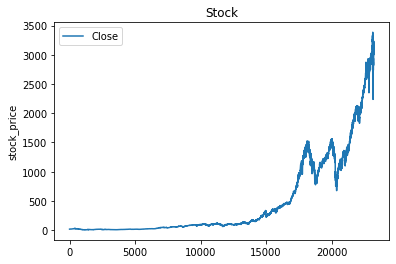

In [4]:
data[['Close']].plot()
plt.ylabel("stock_price")
plt.title("Stock")
plt.show()

In [5]:
df=data[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
df.head()

/home/shreyasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Close
0,-0.992158
1,-0.992099
2,-0.992122
3,-0.992223
4,-0.992158


In [6]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(df, lookback)

In [7]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [9]:
model = LSTM(input_dim=1, hidden_dim=16, output_dim=1, num_layers=2)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
hist = np.zeros(100)
lstm = []
for t in range(100):
    y_train_pred = model(x_train)    
    loss = criterion(y_train_pred, y_train)
    print("epoch ", t, "loss: ", loss.item())
    hist[t] = loss.item()    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

epoch  0 loss:  1.2289127111434937
epoch  1 loss:  1.066201090812683
epoch  2 loss:  0.9049499034881592
epoch  3 loss:  0.7229641079902649
epoch  4 loss:  0.5129319429397583
epoch  5 loss:  0.2890082001686096
epoch  6 loss:  0.10248866677284241
epoch  7 loss:  0.029389789327979088
epoch  8 loss:  0.0909225270152092
epoch  9 loss:  0.13827595114707947
epoch  10 loss:  0.1318044662475586
epoch  11 loss:  0.09948302805423737
epoch  12 loss:  0.06571262329816818
epoch  13 loss:  0.04263751953840256
epoch  14 loss:  0.032733842730522156
epoch  15 loss:  0.03315083682537079
epoch  16 loss:  0.03919782117009163
epoch  17 loss:  0.046524204313755035
epoch  18 loss:  0.05216178670525551
epoch  19 loss:  0.05469134822487831
epoch  20 loss:  0.053935084491968155
epoch  21 loss:  0.050536055117845535
epoch  22 loss:  0.04558081552386284
epoch  23 loss:  0.04029124602675438
epoch  24 loss:  0.035772766917943954
epoch  25 loss:  0.032811492681503296
epoch  26 loss:  0.03173559531569481
epoch  27 los

In [11]:
y_test_pred = model(x_test)
loss = criterion(y_test_pred, y_test)

In [12]:
loss.item()

0.6533375382423401

In [13]:
y_pred=torch.cat((y_train_pred,y_test_pred),dim=0).detach()
y=torch.cat((y_train,y_test),dim=0).detach()

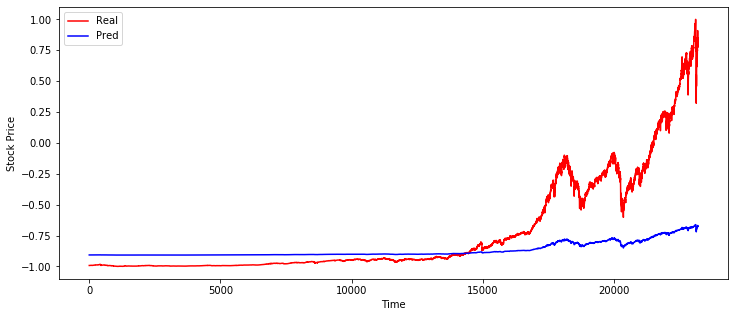

In [14]:
plt.figure(1, figsize=(12, 5))
plt.plot(y, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Pred')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [15]:
y_pred

tensor([[-0.9070],
        [-0.9070],
        [-0.9070],
        ...,
        [-0.6745],
        [-0.6740],
        [-0.6757]])